# Chapter 2: Modelling and Evaluation - Analyse

In [2]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [3]:
etf_daily = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD  EUNL.DE.csv')
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

## Statistical Significance Test and P-Values

## t-Tests

### Idee und Hypothosen

Aus den Korrelationsdaten und das Streudiagramm konnte man einen Zusammenhang zwischen dem Leitzins der EZB und den Adj Close Value des ETFs erkennen.

Daraus wurden folgende Hypothesen erstellt:

* Nullhypothese (H0): Es besteht keine statistisch signifikante Beziehung zwischen den Closed Adj.Value des MSCI World und dem Leitzins der EU-Zentralbank. Der Leitzins der EU-Zentralbank hat keinen signifikanten Enfluss auf den Closed Adj.Value des Aktienmarktes
* Alternativhypothese (H1): Es besteht eine statistisch signifikante Beziehung zwischen Closed Adj.Value des MSCI World und dem Leitzins der EU-Zentralbank. Der Leitzins der EU-Zentralbankhat hat einen signifikanten Enfluss auf den Closed Adj.Value des Aktienmarktes

t-Statistic: 159.82185338543297
p-value: 0.0

Durchschnittliche Werte:
Durchschnittliche t-Statistik: 160.32290361795998
Durchschnittlicher p-Wert: 0.0


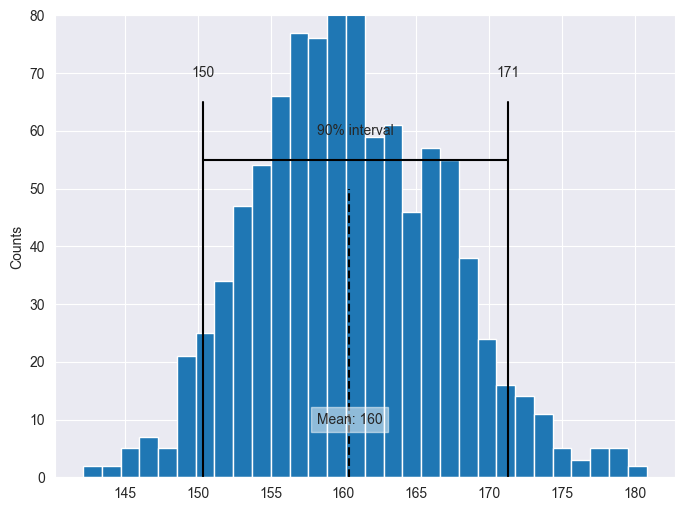

In [23]:
etf_daily = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
EZB_Funds = pd.read_csv('data/leitzins Europa.csv')

eu_funds_sorted = EZB_Funds.sort_values(by='Date')
eu_funds_sorted.to_csv('data/generatedDatasets/leitzins Europa_sorted.csv', index=False)

# Werte für den t-Test extrahieren
etf_filtered = etf_daily.loc[(etf_daily['Date'] >= '2009-09-25') & (etf_daily['Date'] <= '2023-06-01'), ['Date', 'Adj Close']]
eu_funds_filtered = eu_funds_sorted.loc[(eu_funds_sorted['Date'] >= '2009-09-25') & (eu_funds_sorted['Date'] <= '2023-06-01'), ['Date', 'Percent per annum']]

etf_filtered.dropna(inplace=True)
eu_funds_filtered.dropna(inplace=True)

# print(etf_filtered)
# print(eu_funds_filtered)

# t-Test durchführen
t_statistic, p_value = stats.ttest_ind(etf_filtered['Adj Close'], eu_funds_filtered['Percent per annum'])

# Ausgabe der Ergebnisse
print("t-Statistic:", t_statistic)
print("p-value:", p_value)


data = [etf_filtered['Adj Close'], eu_funds_filtered['Percent per annum']]


# -------------------------------------------------------------------------------------------------------
# Bootstrap-Sampling
num_bootstrap_samples = 1000
bootstrap_samples = []

for _ in range(num_bootstrap_samples):
    sample_etf = np.random.choice(etf_filtered['Adj Close'], size=len(etf_filtered), replace=True)
    sample_eu_funds = np.random.choice(eu_funds_filtered['Percent per annum'], size=len(eu_funds_filtered), replace=True)
    bootstrap_samples.append((sample_etf, sample_eu_funds))

# print(bootstrap_samples)

# t-Test für Bootstrap-Samples durchführen
t_test_results = []

for sample_etf, sample_eu_funds in bootstrap_samples:
    t_statistic, p_value = stats.ttest_ind(sample_etf, sample_eu_funds)
    t_test_results.append((t_statistic, p_value))

# Durchschnittliche t-Statistik und p-Wert berechnen
average_t_value = np.mean([result[0] for result in t_test_results])
average_p_value = np.mean([result[1] for result in t_test_results])

# Ausgabe der Ergebnisse
print()
print("Durchschnittliche Werte:")
print("Durchschnittliche t-Statistik:", average_t_value)
print("Durchschnittlicher p-Wert:", average_p_value)

#------------------------------------------------------
# Bootstrap-Sampling-Funktion
def bootstrap_sample(data, n_samples):
    samples = []
    n = len(data)
    for _ in range(n_samples):
        resampled_data = np.random.choice(data, size=n, replace=True)
        samples.append(resampled_data)
    return samples

# Bootstrap-Sampling
n_bootstrap_samples = 1000
etf_samples = bootstrap_sample(etf_filtered['Adj Close'], n_bootstrap_samples)
eu_funds_samples = bootstrap_sample(eu_funds_filtered['Percent per annum'], n_bootstrap_samples)

# t-Test für jedes Bootstrap-Sample durchführen und Ergebnisse speichern
bootstrap_results = []
for i in range(n_bootstrap_samples):
    t_statistic_bs, _ = stats.ttest_ind(etf_samples[i], eu_funds_samples[i])
    bootstrap_results.append(t_statistic_bs)

# Konfidenzintervall berechnen
results = pd.Series(bootstrap_results)
confidence_interval = list(results.quantile([0.05, 0.95]))

# Diagramm erstellen
ax = results.plot.hist(bins=30, figsize=(8, 6))
ax.plot(confidence_interval, [55, 55], color='black')
for x in confidence_interval:
    ax.plot([x, x], [0, 65], color='black')
    ax.text(x, 70, f'{x:.0f}',
            horizontalalignment='center', verticalalignment='center')
ax.text(sum(confidence_interval) / 2, 60, '90% interval',
        horizontalalignment='center', verticalalignment='center')

mean_of_standard_deviation_adj_close = results.mean()
ax.plot([mean_of_standard_deviation_adj_close, mean_of_standard_deviation_adj_close], [0, 50], color='black', linestyle='--')
ax.text(mean_of_standard_deviation_adj_close, 10, f'Mean: {mean_of_standard_deviation_adj_close:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')

ax.set_ylim(0, 80)
ax.set_ylabel('Counts')

plt.show()

### Ergebnis
Die t-Statistik beträgt 160.4640825452364 und die durchschnittliche t-Statistik beträgt 160.68733124355262. Dies deutet darauf hin, dass es eine starke statistische Abweichung zwischen den Adj. Close-Werten und den Leitzins-Werten gibt.

Der (durchschnittliche) p-Wert liegt 0.0. Dies deutet darauf hin, dass die Unterschiede zwischen den Adj. Close-Werten und den Leitzins-Werten höchstwahrscheinlich nicht zufällig und statistisch signifikant sind.

Da der p-Wert bei 0 ist, haben wir ausreichende Beweise, um die Nullhypothese abzulehnen. Das bedeutet, dass die H0 Hypothese ablehnen können. Hingegen unterstützt das Ergebnis die Alternativhypothese und deutet darauf hin, dass der Leitzins der EU-Zentralbank einen signifikanten Einfluss auf den Closed Adj.Value des MSCI World hat.

## ANOVA

### Idee und Hypothesen

Aus den Korrelationsdaten und das Streudiagramm konnte man einen Zusammenhang zwischen dem Leitzins der FED für Banken und den Adj Close Value des ETFs erkennen.

Daraus wurden folgende Hypothesen erstellt:

* Nullhypothese (H0): Es besteht keine statistisch signifikante Beziehung zwischen den Closed Adj.Value des MSCI World und dem Leitzins der FED. Der Leitzins der FED hat keinen signifikanten Einfluss auf den Closed Adj.Value des Aktienmarktes
* Alternativhypothese (H1): Es besteht eine statistisch signifikante Beziehung zwischen Closed Adj.Value des MSCI World und dem Leitzins der FED. Der Leitzins der FED hat einen signifikanten Einfluss auf den Closed Adj.Value des Aktienmarktes

f_statistic: 794.7860225980298
p-value: 1.7224830516974336e-153


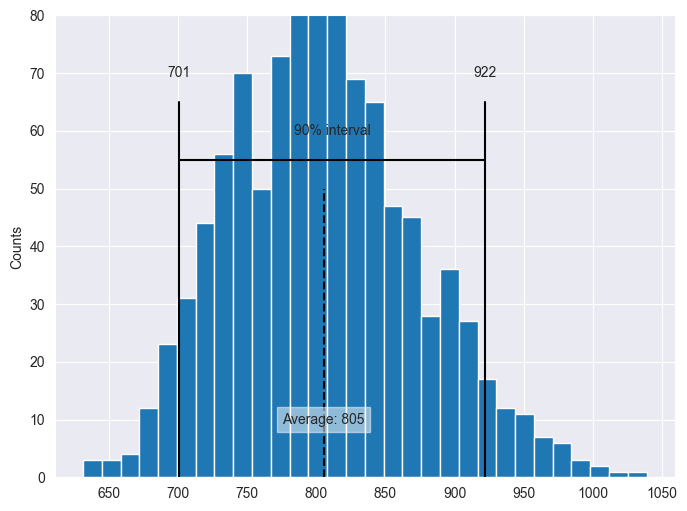


Durchschnittliche Werte:
Durchschnittliche F-Statistic: 805.2092669911804
Durchschnittlicher p-value: 1.9964283618730643e-138


In [28]:
# Daten einlesen
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds_for_banks = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')
fed_funds_for_customers = pd.read_csv('data/generatedDatasets/Leitzins_USA_FED_Kunden_aufgefuellt.csv')
# Werte für den t-Test extrahieren
etf_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-04-01'), ['Date', 'Adj Close']]
fed_funds_for_banks_filtered = fed_funds_for_banks.loc[(fed_funds_for_banks['DATE'] >= '2009-10-01') & (fed_funds_for_banks['DATE'] <= '2023-04-01'), ['DATE', 'FEDFUNDS']]
fed_funds_for_customer_filtered = fed_funds_for_customers.loc[(fed_funds_for_customers['DATE'] >= '2009-10-01') & (fed_funds_for_customers['DATE'] <= '2023-04-01'), ['DATE', 'PRIME']]


# Daten zusammenführen
etf_fedfunds_filtered_combined = pd.merge(etf_filtered, fed_funds_for_banks_filtered, left_on='Date', right_on='DATE', how='inner')
etf_fedfunds_filtered_combined = pd.merge(etf_fedfunds_filtered_combined, fed_funds_for_customer_filtered, left_on='Date', right_on='DATE', how='inner')

etf_fedfunds_filtered_combined.drop('DATE_x', axis=1, inplace=True)
etf_fedfunds_filtered_combined.drop('DATE_y', axis=1, inplace=True)


etf_fedfunds_filtered_combined.to_csv('data/generatedDatasets/combined_fed_funds_filtered.csv', index=False)

#Anova Test

anova_result = stats.f_oneway(etf_fedfunds_filtered_combined['Adj Close'], etf_fedfunds_filtered_combined['FEDFUNDS'], etf_fedfunds_filtered_combined['PRIME'])
print('f_statistic:', anova_result.statistic)
print('p-value:', anova_result.pvalue)

#-----------------------------------
# Bootstrap-Sampling
num_bootstrap_samples = 1000
bootstrap_samples = []

for _ in range(num_bootstrap_samples):
    sample = etf_fedfunds_filtered_combined.sample(frac=1, replace=True)
    bootstrap_samples.append(sample)

# Ergebnisse des Anova-Tests für jedes Bootstrap-Sample speichern
anova_results = []
for sample in bootstrap_samples:
    anova_result = stats.f_oneway(sample['Adj Close'], sample['FEDFUNDS'], sample['PRIME'])
    anova_results.append(anova_result)

# Durchschnitt der F-Statistik und des p-Wertes berechnen
f_statistic_avg = np.mean([result.statistic for result in anova_results])
p_value_avg = np.mean([result.pvalue for result in anova_results])

# Bootstrap-Konfidenzintervall-Diagramm
results = pd.Series([result.statistic for result in anova_results])

confidence_interval = list(results.quantile([0.05, 0.95]))

ax = results.plot.hist(bins=30, figsize=(8, 6))
ax.plot(confidence_interval, [55, 55], color='black')
for x in confidence_interval:
    ax.plot([x, x], [0, 65], color='black')
    ax.text(x, 70, f'{x:.0f}',
            horizontalalignment='center', verticalalignment='center')
ax.text(sum(confidence_interval) / 2, 60, '90% interval',
        horizontalalignment='center', verticalalignment='center')

ax.plot([f_statistic_avg, f_statistic_avg], [0, 50], color='black', linestyle='--')
ax.text(f_statistic_avg, 10, f'Average: {f_statistic_avg:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')

ax.set_ylim(0, 80)
ax.set_ylabel('Counts')

plt.show()

# Ergebnisse anzeigen
print()
print("Durchschnittliche Werte:")
print("Durchschnittliche F-Statistic:", f_statistic_avg)
print("Durchschnittlicher p-value:", p_value_avg)

### Ergebnis
Die durchschnittliche F-Statistic beträgt 806.6115787154686. Dies deutet darauf hin, dass es eine starke statistische Abweichung zwischen den Adj. Close-Werten und den FED Leitzins-Werten gibt.

Der durchschnittliche p-Wert beträgt 4.329161761687896e-133, dieser Wert liegt sehr nahe beim Wert Null. Dies deutet darauf hin, dass die Unterschiede zwischen den Adj. Close-Werten und den Leitzins-Werten höchstwahrscheinlich nicht zufällig und statistisch signifikant sind.

Aus den Ergebnissen des ANOVA-Tests kann nun interpretiert werden, dass Angesichts des kleinen p-Werts kann man die Nullhypothese (H0) ablehnen und akzeptieren die Alternativhypothese (H1). Dies bedeutet, dass es eine statistisch signifikante Beziehung zwischen dem Closed Adj.Value des MSCI World und dem Leitzins der FED gibt, und der Leitzins der FED einen signifikanten Einfluss auf den Closed Adj.Value des Aktienmarktes hat.

Die Durchschnittswerte der F-Statistik (794.7860225980298) und des p-Werts (1.7224830516974336e-153) über die Bootstrap-Samples unterstützen ebenfalls die Schlussfolgerung, dass H1 zutrifft.
.

## Chi-Square Test

### Erklärung und Idee
Definition der Hypothesen:
   * Nullhypothese (H0): Es besteht kein Zusammenhang zwischen der Rendite des ETFs und den Währungsumtauschdaten.
   * Alternativhypothese (HA): Es besteht ein Zusammenhang zwischen der Rendite des ETFs und den Währungsumtauschdaten.

Um einen Chi-Quadrat-Test auf die Rendite eines ETFs und die Währungsumtauschdaten durchzuführen, müssen die Variablen kategorische oder diskrete Werte haben, damit der Chi-Quadrat-Test angewendet werden kann.

Dafür müssen kontinuierlichen Daten der Rendite und Währungsumtausch in kategorische oder diskrete Werte konvertiertt werden. Hierbei werden die Häufigkeiten der Kombinationen von Werten aus den Spalten 'Daily Return' und 'USD_EUR_Exch_Rate' zu einer Kontingenztabelle zusammengestellt.

Nachdem nun eine Kontingenztabelle erstellt wurde, kann ein Chi-Quadrat-Test durchgeführt werden.

In [7]:
etf_with_return = pd.read_csv('data/generatedDatasets/iShares Core MSCI World UCITS ETF USD (Acc) Daily - Rendite.csv')

etf_with_return_filtered = etf_with_return.loc[(etf_with_return['Date'] >= '2009-09-25') & (etf_with_return['Date'] <= '2023-06-01'), ['Date', 'Daily Return']]


# Berechnung des Anstiegs oder Abstiegs zum Vortag
etf_with_return['Change'] = etf_with_return['Daily Return'].diff().fillna(0)

# Vergleich der Veränderung der Rendite zum Vortag
etf_with_return['Comparison'] = etf_with_return['Change'].apply(lambda x: 'positiv' if x > 0 else 'negativ' if x < 0 else 'stabil')

etf_with_return.to_csv('data/generatedDatasets/iShares Core MSCI World UCITS ETF USD (Acc) Daily - Rendite with Comparison Metric.csv', index=False)

# Überprüfung der vorhandenen Werte in der Spalte 'Comparison'
# print(etf_with_return['Comparison'].unique())

# Summierung der Werte in der Spalte 'Comparison'
summary_table_of_return_value_comparison = etf_with_return['Comparison'].value_counts().reset_index()

# Umbenennung der Spalten
summary_table_of_return_value_comparison.columns = ['Status', 'Anzahl']

# Umformatierung der Tabelle
summary_table_of_return_value_comparison = summary_table_of_return_value_comparison.pivot_table(index=None, columns='Status', values='Anzahl', fill_value=0)
# Entfernen der Spalte "stabil"
summary_table_of_return_value_comparison = summary_table_of_return_value_comparison.drop('stabil', axis=1)


# Ausgabe der Zusammenfassungstabelle
print('Zusammenfassung Vergleich der Renditen: ')
print(summary_table_of_return_value_comparison)

# --------------------------------------------------------------------------------------------------------------------------

usd_eur_exchange = pd.read_csv('data/generatedDatasets/ERR_USD_Clean.csv')

usd_eur_exchange_filtered = usd_eur_exchange.loc[(usd_eur_exchange['Date'] >= '2009-09-25') & (usd_eur_exchange['Date'] <= '2023-06-01'), ['Date', 'ECB Nominal effective exch. rate of the US dollar against Narrow EER group of trading partners (fixed composition): EER-12']]

usd_eur_exchange_filtered = usd_eur_exchange_filtered.rename(columns={'ECB Nominal effective exch. rate of the US dollar against Narrow EER group of trading partners (fixed composition): EER-12': 'nom. exch. Rate USD-EUR'})

# Umwandlung der Spalte in numerische Werte
usd_eur_exchange_filtered['nom. exch. Rate USD-EUR'] = pd.to_numeric(usd_eur_exchange_filtered['nom. exch. Rate USD-EUR'], errors='coerce')

# Basispunkt definieren
basispunkt = 100

# Vergleichsfunktion für den neuen Spaltenwert
def compare_to_basispoint(value):
    if value < basispunkt:
        return 'negativ'
    elif value > basispunkt:
        return 'positiv'
    elif pd.isna(value):
        return 'empty'
    else:
        return 'stabil'

# Neue Spalte erstellen und mit den Vergleichswerten füllen
usd_eur_exchange_filtered['Comparison'] = usd_eur_exchange_filtered['nom. exch. Rate USD-EUR'].apply(compare_to_basispoint)

usd_eur_exchange_filtered.to_csv('data/generatedDatasets/ERR_USD_Clean_With_Comparison_Metric.csv', index=False)

# Summieren der Werte in der Spalte 'Comparison'
summary_table = usd_eur_exchange_filtered['Comparison'].value_counts().reset_index()

# Umbenennung der Spalten
summary_table.columns = ['Status', 'Anzahl']

# Hinzufügen fehlender Status-Werte und Füllen mit 0
summary_table = summary_table.pivot_table(index=None, columns='Status', values='Anzahl', fill_value=0)
# Entfernen der Spalte "stabil"
summary_table = summary_table.drop('empty', axis=1)

# Ausgabe der neuen Tabelle
print()
print('Zusammenfassung Vergleich der Exchange Rate USD-EUR: ')
print(summary_table)


Zusammenfassung Vergleich der Renditen: 
Status  negativ  positiv
Anzahl     1794     1635

Zusammenfassung Vergleich der Exchange Rate USD-EUR: 
Status  negativ  positiv
Anzahl     3222      256


In [8]:
import pandas as pd
from scipy.stats import chi2_contingency

# Daten einlesen
usd_eur_exchange_filtered = pd.read_csv('data/generatedDatasets/ERR_USD_Clean_With_Comparison_Metric.csv')
etf_with_return_filtered = pd.read_csv('data/generatedDatasets/iShares Core MSCI World UCITS ETF USD (Acc) Daily - Rendite with Comparison Metric.csv')

# Kreuztabelle erstellen
cross_table = pd.crosstab(usd_eur_exchange_filtered['Comparison'], etf_with_return_filtered['Comparison'])

print(cross_table)
print()

# Chi-Quadrat-Test durchführen
chi2, p_value, _, _ = chi2_contingency(cross_table)

# Ergebnis ausgeben
print("Chi-Quadrat-Test Ergebnis:")
print("Chi2-Statistik:", chi2)
print("p-Wert:", p_value)

# ---------------------------------------------

# Anzahl der Bootstraps
num_bootstraps = 500

# Speicher Arrays für die p-values und chi-qrt_values
bootstrap_chi2_values = []
bootstrap_p_values = []

for i in range(num_bootstraps):
    # Zufällige Stichprobe mit Zurücklegen aus den Daten ziehen
    bootstrap_sample = etf_with_return_filtered.sample(frac=1, replace=True)

    # Erstellen der Kontingenztabelle für die Bootstrap-Stichprobe
    bootstrap_contingency_table = pd.crosstab(usd_eur_exchange_filtered['Comparison'], etf_with_return_filtered['Comparison'])

    # Durchführung des Chi-Quadrat-Tests für die Bootstrap-Stichprobe --> gib noch "Freiheitsgrade" und Erwartete Häufigkeiten zurück, wird aber nicht gebraucht
    bootstrap_chi2, bootstrap_p_value, _, _ = chi2_contingency(bootstrap_contingency_table)

    # Speichern der Ergebnisse in den Listen
    bootstrap_chi2_values.append(bootstrap_chi2)
    bootstrap_p_values.append(bootstrap_p_value)

# Berechnung des Mittelwerts der Chi-Quadrat-Statistiken und p-Werte
mean_chi2 = np.mean(bootstrap_chi2_values)
mean_p_value = np.mean(bootstrap_p_values)

print()
print("Durchschnittliche Werte:")
print("Mittelwert der Chi-Quadrat-Statistiken:", mean_chi2)
print("Mittelwert der p-Werte:", mean_p_value)

Comparison  negativ  positiv  stabil
Comparison                          
empty           548      477       8
negativ        1116     1045       4
positiv         130      113      13

Chi-Quadrat-Test Ergebnis:
Chi2-Statistik: 77.40614180275973
p-Wert: 6.170125165820085e-16

Durchschnittliche Werte:
Mittelwert der Chi-Quadrat-Statistiken: 77.40614180275972
Mittelwert der p-Werte: 6.170125165820084e-16
